---
# XAI-AttackBench Demo Notebook (Synthetic Data)

This notebook demonstrates the **end-to-end pipeline** on a **synthetic tabular dataset** for the Greedy Hill Climb attack:

- create a dataset with **numerical + categorical** features
- train a model
- fit an explainer (**LIME** or **SHAP Kernel**)
- run a **black-box** attack (**GreedyHillClimb**) that tries to **change explanations** while keeping predictions similar
- compare explanation vectors before/after
- visualize the attack


In [1]:
# std-lib imports
from pathlib import Path
import tempfile

# 3-party imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

# Projekt imports

# base imports
from xai_bench.datasets.base_dataset import BaseDataset
from xai_bench.base import BaseMetric

# models / explainers / attacks
from xai_bench.models.random_forest import SKRandomForest
from xai_bench.explainer.lime_explainer import LimeTabularAdapter
from xai_bench.explainer.shap_explainer import ShapAdapter
from xai_bench.attacks.greedy_hill_climb import GreedyHillClimb

# metrics
from xai_bench.metrics.l2_metric import L2Metric

---
## 0) Seed

In [2]:
seed = 0

---
## 1) Create a synthetic dataset

We create a **tiny and interpretable** synthetic loan approval dataset with only **3 input features**:

- **numerical** (already normalized):
  - `income` (z-scored)
  - `age` (z-scored)
- **categorical**:
  - `existing_customer` with values `new` / `existing`  (converted via **one-hot encoding** into `existing_customer_existing`)

The binary target `loan_approved` is generated from a **non-linear decision rule**
(including interactions + noise), so the model behavior is realistic enough.

In [3]:
class TinySyntheticDataset(BaseDataset):
    def __init__(self, path: str, random_state: int = 42, **kwargs):
        self.categorical_features = ["existing_customer"]      
        self.numerical_features = ["income", "age"]     
        self.target = "loan_approved"
        self.task = "classification"
        super().__init__(path=path, random_state=random_state, stratify=True, **kwargs)


    def decode_instance(self, x_scaled: np.ndarray) -> dict:
        cols = list(self.features.feature_names_model)
        out = {}

        if hasattr(self, "scaler") and self.scaler is not None:
            num_feats = self.numerical_features or []
            if len(num_feats) > 0:
                idx = [cols.index(f) for f in num_feats]
                x_num_scaled = x_scaled[idx].reshape(1, -1)
                x_num = self.scaler.inverse_transform(x_num_scaled)[0]
                for f, v in zip(num_feats, x_num):
                    out[f] = float(v)

        for logical_feat, subcols in self.feature_mapping.items():
            if logical_feat in (self.numerical_features or []):
                continue

            if len(subcols) == 1 and subcols[0] == logical_feat:
                continue

            vals = {c: x_scaled[cols.index(c)] for c in subcols if c in cols}
            if not vals:
                continue

            chosen = max(vals, key=vals.get)
            out[logical_feat] = chosen.split("_")[-1]

        return out


    def read(self) -> pd.DataFrame:
        self.df_raw = pd.read_csv(self.path)
        return self.df_raw

    def preprocess(self) -> pd.DataFrame:
        df = self.df_raw.copy()
        self.y_full = df[self.target].astype(int)

        X = df.drop(columns=[self.target]).copy()

        dummies = pd.get_dummies(
            X["existing_customer"],
            prefix="existing_customer",
            drop_first=True
        ).astype(float)

        X = pd.concat([X.drop(columns=["existing_customer"]), dummies], axis=1)

        dummy_cols = list(dummies.columns)  
        self.feature_mapping = {
            "income": ["income"],
            "age": ["age"],
            "existing_customer": dummy_cols, 
        }

        self.categorical_values = {"existing_customer": np.array([0.0, 1.0])}
        self.scaled_categorical_values = self.categorical_values

        self.X_full = X.astype(float)
        return self.X_full



def make_tiny_df(n=2000, seed=42):
    rng = np.random.default_rng(seed)

    income = np.clip(rng.normal(60, 20, size=n), 10, 150)   # k$
    age = rng.integers(18, 70, size=n)

    existing_customer = rng.choice(["new", "existing"], size=n, p=[0.5, 0.5])

    income = (income - income.mean()) / (income.std() + 1e-8)
    age = (age - age.mean()) / (age.std() + 1e-8)

    group = np.where(existing_customer == "existing", 1.0, -1.0)

    # target rule
    logit = (
        1.2 * income
        + 0.6 * np.tanh(age)
        + 0.7 * group
        - 0.8 * income * np.tanh(age)
        + 0.25 * rng.normal(0, 1, size=n)
    )
    p = 1 / (1 + np.exp(-logit))
    y = (p > 0.5).astype(int)

    return pd.DataFrame({
        "income": income.astype(float),
        "age": age.astype(float),
        "existing_customer": existing_customer,
        "loan_approved": y
    })


tmp = tempfile.TemporaryDirectory()
csv_path = Path(tmp.name) / "tiny_synth.csv"
df = make_tiny_df(n=2000, seed=42)
df.to_csv(csv_path, index=False)

dataset = TinySyntheticDataset(path=str(csv_path), test_size=0.2, random_state=42)

print("X_train_scaled shape:", dataset.X_train_scaled.shape)
print("Features:", dataset.features.feature_names_model) 

X_train_scaled shape: (1600, 3)
Features: ['income', 'age', 'existing_customer_new']


### 1.1) Visualize Dataset

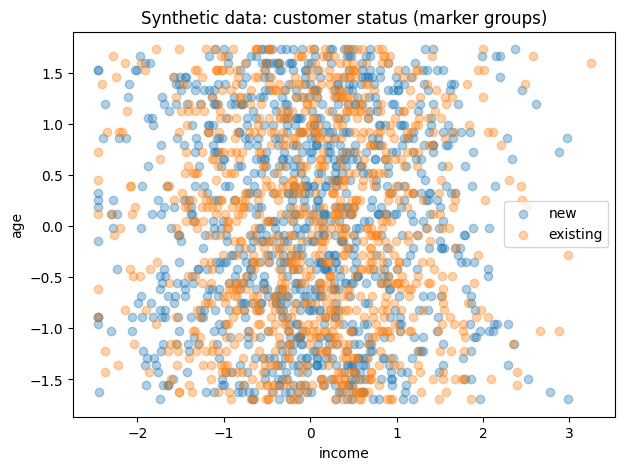

In [4]:
dfp = df.copy()
dfp["existing_customer_dummy"] = (dfp["existing_customer"] == "existing").astype(int)

plt.figure(figsize=(7,5))
m0 = dfp["existing_customer_dummy"] == 0
m1 = ~m0
plt.scatter(dfp.loc[m0,"income"], dfp.loc[m0,"age"], alpha=0.35, label="new")
plt.scatter(dfp.loc[m1,"income"], dfp.loc[m1,"age"], alpha=0.35, label="existing")
plt.title("Synthetic data: customer status (marker groups)")
plt.xlabel("income")
plt.ylabel("age")
plt.legend()
plt.show()

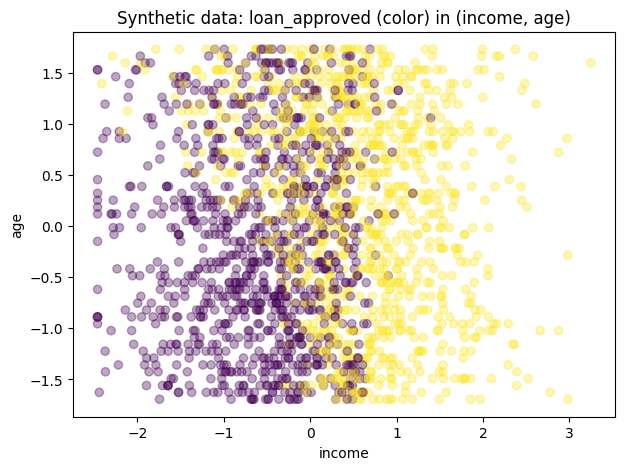

In [5]:
plt.figure(figsize=(7,5))
plt.scatter(dfp["income"], dfp["age"], c=dfp["loan_approved"], alpha=0.35)
plt.title("Synthetic data: loan_approved (color) in (income, age)")
plt.xlabel("income")
plt.ylabel("age")
plt.show()

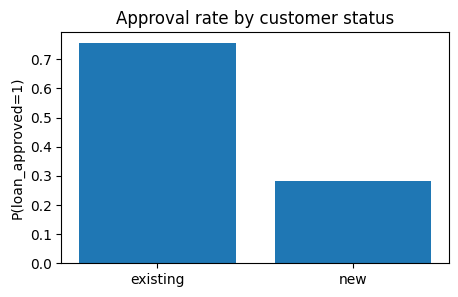

In [6]:
rates = dfp.groupby("existing_customer")["loan_approved"].mean()
plt.figure(figsize=(5,3))
plt.bar(rates.index.astype(str), rates.values)
plt.title("Approval rate by customer status")
plt.ylabel("P(loan_approved=1)")
plt.show()

---
## 2) Train a model (Random Forest)

We use the repo's `SKRandomForest` model wrapper (black-box access via `predict`/`predict_proba`).


In [7]:
model = SKRandomForest(
    task=dataset.task,
    n_estimators=100,
    random_state=seed,
    max_depth=12
)

Xtr = dataset.X_train_scaled.values
ytr = dataset.y_train.values
Xte = dataset.X_test_scaled.values
yte = dataset.y_test.values

model.fit(Xtr, ytr)
acc = accuracy_score(yte, model.predict(Xte))
print("Test accuracy:", acc)


Test accuracy: 0.9075


---
## 3) Fit explainers

In [8]:
EXPLAINER = "lime"  # "shap"

if EXPLAINER == "lime":
    explainer = LimeTabularAdapter(dataset=dataset, num_samples=150, random_state=seed)
elif EXPLAINER == "shap":
    explainer = ShapAdapter(dataset=dataset, nsamples=75, background_size=50, random_state=seed)
else:
    raise ValueError("EXPLAINER must be 'lime' or 'shap'")

explainer.fit(dataset.X_train_scaled.values, model, dataset.features)
print("Explainer fitted:", explainer.__class__.__name__)

Explainer fitted: LimeTabularAdapter


---
## 4) Visualize the GreedyHillClimb search


In [9]:
metric: BaseMetric = L2Metric()  # explanation drift metric used by the attack

attack = GreedyHillClimb(
    dataset=dataset,
    model=model,
    explainer=explainer,
    metric=metric,
    epsilon=0.05,
    num_climbs=40,
    num_derections=15,
    max_trys=1,
    step_len=0.001,
    proba_numeric=0.8,
    seed=seed,
    num_samples_explainer= 30,
    task=dataset.task
)

In [10]:
rng = np.random.default_rng(seed)
idx = rng.choice(len(Xte), size=1, replace=False)

X_example = Xte[idx]
y_example = yte[idx]

### 4.1) Run the GreedyHillClimb search

In [11]:
x0 = X_example[-1].copy()

x_adv_trace, trace = attack._trace_generate(x0)

cols = list(dataset.features.feature_names_model)
ix_income = cols.index("income")
ix_age    = cols.index("age")

dummy_cols = [c for c in cols if c.startswith("existing_customer_")]
ix_exist = cols.index(dummy_cols[0])

path = np.asarray(trace["path"])
cand_all = np.vstack([np.asarray(C) for C in trace["cand_x"]])
scores = np.concatenate([np.asarray(s).reshape(-1) for s in trace["cand_scores"]])  

print("Steps recorded:", len(trace["path"]) - 1)
print("Pred Class bevor Attack:", model.predict(x0.reshape(1,-1))[0], " Pred Class avter Attack:", model.predict(x_adv_trace.reshape(1,-1))[0])

Steps recorded: 40
Pred Class bevor Attack: 0  Pred Class avter Attack: 0


### 4.2) Visualize candidates + chosen move for the first step

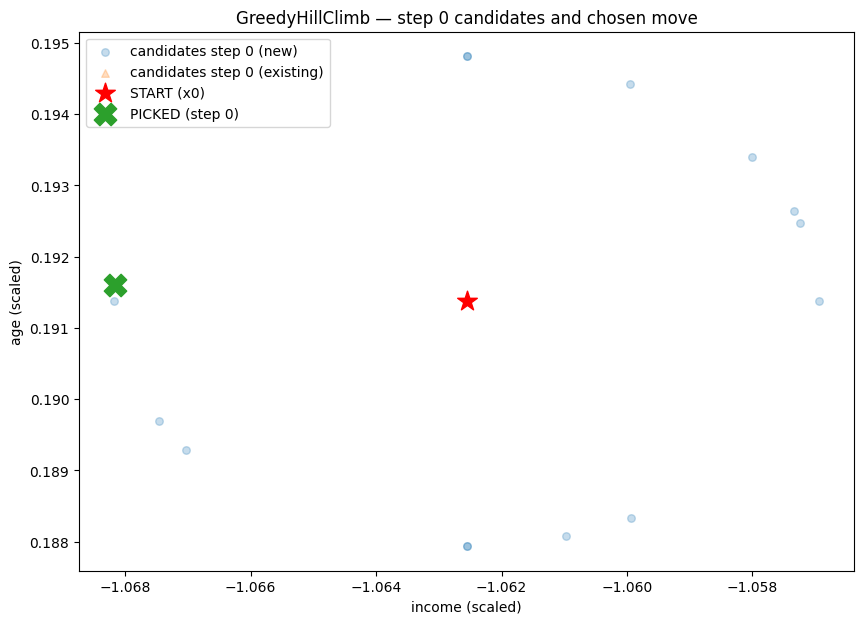

In [12]:
C0 = np.asarray(trace["cand_x"][0])
j0 = int(trace["picked_idx"][0])
x0 = path[0]

m_new = C0[:, ix_exist] < 0.5
m_old = ~m_new

plt.figure(figsize=(10,7))
plt.scatter(C0[m_new, ix_income], C0[m_new, ix_age], alpha=0.25, s=30, marker="o", label="candidates step 0 (new)")
plt.scatter(C0[m_old, ix_income], C0[m_old, ix_age], alpha=0.25, s=30, marker="^", label="candidates step 0 (existing)")
plt.scatter(x0[ix_income], x0[ix_age], s=220, marker="*", color="red",  zorder=1000,  label="START (x0)")

if 0 <= j0 < len(C0):
    plt.scatter(C0[j0, ix_income], C0[j0, ix_age], s=260, marker="X", label="PICKED (step 0)")

plt.title("GreedyHillClimb — step 0 candidates and chosen move")
plt.xlabel("income (scaled)")
plt.ylabel("age (scaled)")
plt.legend()
plt.show()

### 4.3) Visualize candidates + chosen path for all steps


#### By Metric Score

/home/nicolas/code/uni/xai/code/Fooling_XAI/venv/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:4671: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


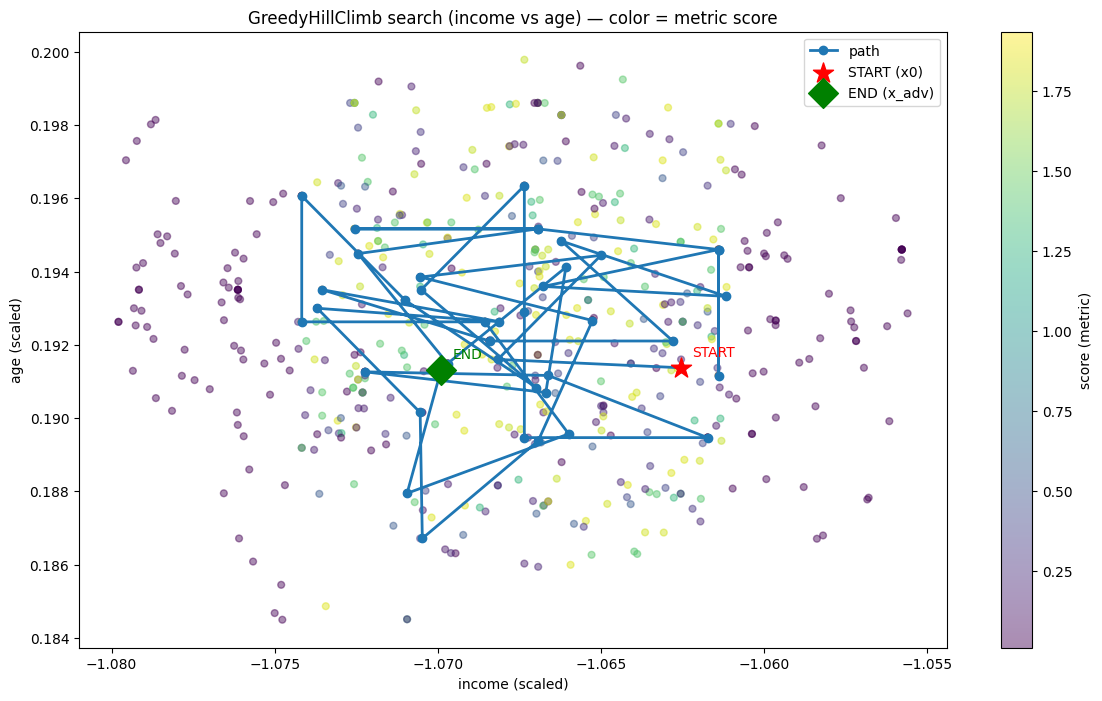

In [14]:
lo, hi = np.percentile(scores, [2, 98])
scores = np.asarray(scores).reshape(-1)

mask = np.isfinite(scores)
scores_f = scores[mask]

if scores_f.size == 0:
    raise ValueError("No finite scores to plot (all are inf/nan).")

lo, hi = np.percentile(scores_f, [2, 98])
scores_c = np.clip(scores, lo, hi)
scores_c[~mask] = lo  

plt.figure(figsize=(14,8))

sc = plt.scatter(cand_all[:, ix_income], cand_all[:, ix_age],c=scores_c, cmap="viridis", alpha=0.45, s=24)
plt.plot(path[:, ix_income], path[:, ix_age], marker="o", linewidth=2, label="path")
plt.scatter(path[0, ix_income],  path[0, ix_age],  s=230, marker="*", zorder=1000,color="red", label="START (x0)")
plt.scatter(path[-1, ix_income], path[-1, ix_age], s=230, marker="D", zorder=1000, color="green", label="END (x_adv)")

plt.annotate("START", (path[0, ix_income], path[0, ix_age]), color="red", zorder=1000, textcoords="offset points", xytext=(8,8))
plt.annotate("END",   (path[-1, ix_income], path[-1, ix_age]), color="green", zorder=1000, textcoords="offset points", xytext=(8,8))


plt.title("GreedyHillClimb search (income vs age) — color = metric score")
plt.xlabel("income (scaled)")
plt.ylabel("age (scaled)")
plt.legend()

cbar = plt.colorbar(sc)
cbar.set_label("score (metric)")

plt.show()

### 4.4 Show which features changed per step (top-5 deltas)

In [15]:
# cols = list(dataset.features.feature_names_model)
# path = trace["path"]
# deltas = path[1:] - path[:-1]

# for t in range(deltas.shape[0]):
#     d = deltas[t]
#     top = np.argsort(np.abs(d))[-5:][::-1]
#     print(f"\nstep {t} -> {t+1}:")
#     for j in top:
#         if d[j] != 0:
#             print(f"  {cols[j]:<12} delta={d[j]: .4f}  new={path[t+1, j]: .4f}")


## 4.5) Show the difference of the real instance and the attacked instance

In [16]:
feature_names = np.array(dataset.features.feature_names_model)

print("=== REAL instance ===")
for f, v in zip(feature_names, path[-1]):
    print(f"{f:25s}: {v:.4f}")

print("\n=== ADV instance ===")
for f, v in zip(feature_names, path[0]):
    print(f"{f:25s}: {v:.4f}")

=== REAL instance ===
income                   : -1.0699
age                      : 0.1913
existing_customer_new    : 0.0000

=== ADV instance ===
income                   : -1.0626
age                      : 0.1914
existing_customer_new    : 0.0000


In [17]:
mean = {
    "income": 60000.0,
    "age": 44.0,
}

std = {
    "income": 20000.0,
    "age": 12.0,
}

def inverse_scale(x_scaled):
    out = {}
    out["income"] = x_scaled[0] * std["income"] + mean["income"]
    out["age"]    = x_scaled[1] * std["age"] + mean["age"]
    out["existing_customer"] = (
        "existing" if x_scaled[2] >= 0.5 else "new"
    )
    return out

print("=== REAL instance (decoded) ===")
for k, v in inverse_scale(path[-1]).items():
    if isinstance(v, (int, float)):
        print(f"{k:25s}: {v:.4f}")
    else:
        print(f"{k:25s}: {v}")

print("\n=== ADV instance (decoded) ===")
for k, v in inverse_scale(path[0]).items():
    if isinstance(v, (int, float)):
        print(f"{k:25s}: {v:.4f}")
    else:
        print(f"{k:25s}: {v}")

=== REAL instance (decoded) ===
income                   : 38602.0452
age                      : 46.2959
existing_customer        : new

=== ADV instance (decoded) ===
income                   : 38748.8467
age                      : 46.2965
existing_customer        : new


## 4.6) Show the prediction of the Modell for the new instances

In [18]:
print(f"Model Prediction bevore the attack: {model.predict(path[0].reshape(1, -1))[0]}")
print(f"Model Prediction avter the attack: {model.predict(path[-1].reshape(1, -1))[0]}")

Model Prediction bevore the attack: 0
Model Prediction avter the attack: 0


## 4.6) Visualize explanation vectors (before vs after)

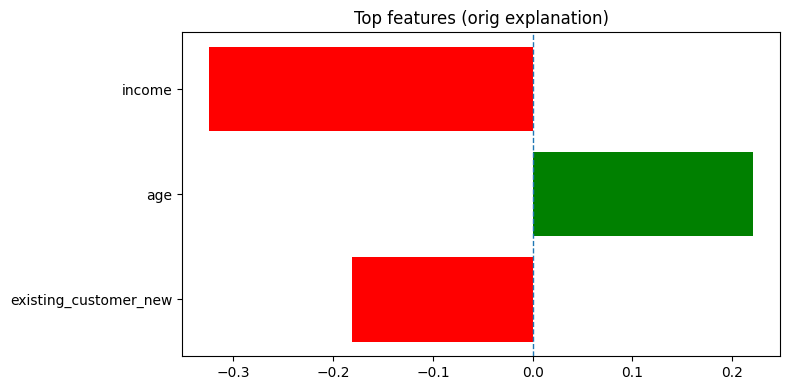

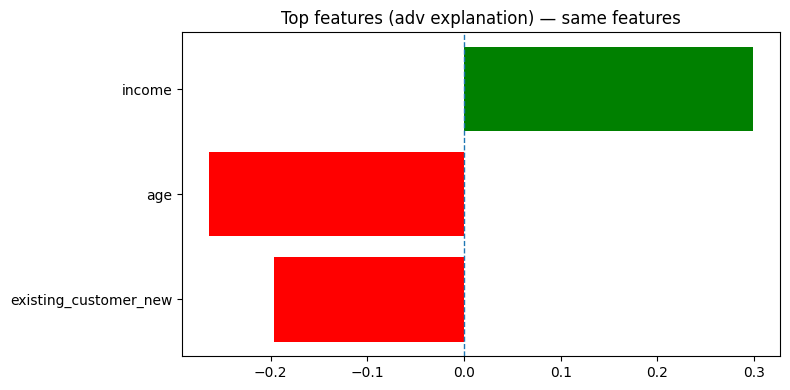

In [19]:
feature_names = np.array(dataset.features.feature_names_model)

explanation_real = np.asarray(explainer.explain(path[0])).squeeze()
explanation_attacked = np.asarray(explainer.explain(path[-1])).squeeze()

if explanation_real.ndim == 2:
    explanation_real = explanation_real[1]
    explanation_attacked = explanation_attacked[1]

def sign_colors(vals):
    return ["green" if v >= 0 else "red" for v in vals]

k = min(12, len(explanation_real))
top = np.argsort(np.abs(explanation_real))[-k:][::-1]

vals0 = explanation_real[top][::-1]
vals1 = explanation_attacked[top][::-1]
names = feature_names[top][::-1]

plt.figure(figsize=(8,4))
plt.barh(names, vals0, color=sign_colors(vals0))
plt.axvline(0, linestyle="--", linewidth=1)
plt.title("Top features (orig explanation)")
plt.tight_layout()
plt.show()

plt.figure(figsize=(8,4))
plt.barh(names, vals1, color=sign_colors(vals1))
plt.axvline(0, linestyle="--", linewidth=1)
plt.title("Top features (adv explanation) — same features")
plt.tight_layout()
plt.show()


---
---